In [1]:
# Basic packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.signal import find_peaks, peak_widths

plt.rcParams['figure.dpi'] = 200
import os # for grabbing all files in folder

# For importing data as a R-like dataframe
import pandas as pd               

# Makes some plots look nicer
plt.style.use('ggplot')  # Set plot style

# Functions for parsing/ploting data

In [3]:
#define functions

def tbs_csv_parse(file_name):
    
    """
    Parses a TBS .csv file and returns the content in a dictionary with keywords as keys.
    
    Parameters
    ----------
    file_name : TBS .csv file
        A csv file from a TBS Tektronix digital oscilloscope.
        
    Returns
    -------
    output : dictionary
        Content of .csv file with keywords as keys.
    
    """
    
    file = open(file_name,"r") #open the .csv file

    read_array = np.array(file.readlines()) #read every line of file

    file.close() #"close file"

    tbs_dict = {} #This is where the information will be stored.

    values_array = [] #This is where the values for each key in the dictionary will be stored.

    horizontal = [] #Data on x-axis
    vertical = [] #Data on y-axis

    for l in range(len(read_array)): #step through every line
        #get rid of white spaces
        line = np.array(read_array[l].replace(' ', '').replace('\n','').split(','))
        #only look at non '' elements
        line = line[line != '']
        if line[0].isalpha(): #Found keyword made of only characters.
            key = line[0] #Set key to keyword.
            #see if values can be changed to integer or float or keep as string.
            try:
                values_array = int(line[1])
            except ValueError:
                try:
                    values_array = float(line[1])
                except ValueError:
                    values_array = line[1]
            horizontal.append(float(line[-2])) #append x data
            vertical.append(float(line[-1])) #append y data

            tbs_dict[key] = values_array #add to dictionary

        else: #there is no keyword
            horizontal.append(float(line[-2]))
            vertical.append(float(line[-1]))

    #Add horizontal and vertical data to dictionary
    tbs_dict['horizontal'] = horizontal
    tbs_dict['vertical'] = vertical 

    return tbs_dict

def grab_all_tbs(path):
    
    """
    Grabs all the data from .csv files and returns a dictionary of dictionaries.
    
    Parameters
    ----------
    path : String
        Path to a folder with tbs .csv files.
    
    Returns
    -------
    output : dictinary of dictionaries
        Dicitonary with name as key for each .csv file. Within each dictionary the keywords from
        the .csv file serve as keys.
    
    """
    list_of_files = [] #Holds a list of files.
    output = {} #dictionary to store input variables
    for root, dirs, files in os.walk(path): #Step through files in path.
        for file in files: #Step through each file.
            if file.endswith('.CSV'): #only select '.csv' files
                list_of_files.append(os.path.join(root,file)) #Append to list of files.
    for name in list_of_files: #Step through each file.
        output[name.split('/')[-1].split('.')[-2]] = tbs_csv_parse(name) #Each key for each dictionary will be Spec_ID.
    return output

def plot_data_tbs(tbs_dict, start, stop, spectrums):
    
    """
    Plots spectrums from dictionary created from Spe files.
    
    Parameters
    ----------
    tbs_dict : dictionary
        Dictionary of dictionaries of all tbs files.
    
    start : float
        Beginning time to start plotting. (selects nearest time)
        
    stop : float
        Ending time to stop plotting. (selects nearest time)
    
    """
    

    colors = cm.rainbow(np.linspace(0, 1, len(tbs_dict.keys()))) #Every spectrum will have a unique color.
    
    #If 'all' then plots all keys
    if spectrums == 'all':
        spectrums = np.sort(list(tbs_dict.keys()))
    
    #Step thrugh each key and color
    for key, color in zip(spectrums, colors):
    
        horizontal = tbs_dict[key]['horizontal']

        #Find nearest values for plotting
        
        #Find closest value in index
        srt = np.abs(np.array(horizontal) - start).argmin()
        stp = np.abs(np.array(horizontal) - stop).argmin()
        x_axis = horizontal[srt:stp]
        plt.xlabel('time (s)')
        #x-axis is channel
            
        #Grab the vertical from the current spectrum based on what is to be plotted.
        current_spec = tbs_dict[key]['vertical'][srt:stp]
        
        plt.plot(x_axis, current_spec, label=key, color=color)
        plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
    
    plt.ylabel('Voltage (V)')
    plt.legend(loc='lower right')
    plt.show()

def analyze_peaks(tx, vy, peaks, peaks_dict, which_peak=0):

    """
    Plots spectrum and peak and calculates rise time, fall time, amplitude, and FWHM.

    Parameters
    ----------
    tx : array
        time in seconds
    vy : array
        voltage in volts ()
    peaks : array
        array of peaks in the series
    peak_dict : dictionary 
        contains peak information like FWHM
    which_peak : integer
        Which peak to be analyzed
    """

    vy = -vy
    tx = tx*10**6 #convert to microseconds

    #grab relevant data from dictionary
    peak = np.array(peaks[which_peak])
    prominence = peaks_dict["prominences"][which_peak]
    left_base = peaks_dict["left_bases"][which_peak]
    right_base = peaks_dict["right_bases"][which_peak]
    width_height = peaks_dict["width_heights"][which_peak]
    left_ips = peaks_dict["left_ips"][which_peak]
    right_ips = peaks_dict["right_ips"][which_peak]

    #Use a linear model to go from point number to time.
    linear_model=np.polyfit(range(len(tx)),tx,1)
    linear_model_fn = np.poly1d(linear_model)

    #calculate full width half max of peak
    #subtract ips from each other and use the linear model for time
    width_FWHM = np.abs(linear_model_fn(left_ips) - linear_model_fn(right_ips))
    #Calculte widths at 90% and 10% for rise and fall time calculations
    width_90 = peak_widths(vy, np.array([peak]), rel_height=0.1)
    width_10 = peak_widths(vy, np.array([peak]), rel_height=0.9)
    #Use this to calculate rise time and fall times
    t_rf = np.abs(linear_model_fn(width_10[2:]) - linear_model_fn(width_90[2:]))
    t_rise = t_rf[0][0]
    t_fall = t_rf[1][0]
    amplitude = (vy[peak] - (vy[peak] - prominence))
    v_rf=np.ravel([np.full((1,2),np.ravel(width_10[1])),np.full((1,2),np.ravel(width_90[1]))])
    t_rf=linear_model_fn(np.ravel([width_10[2:4],width_90[2:4]]))

    #plot results
    plt.figure()
    plt.subplot(211)
    plt.plot(tx, -vy)
    plt.xlabel('time ($\mu$s)')
    plt.ylabel('voltage (V)')
    plt.tight_layout()


    plt.subplot(212)
    plt.plot(tx[left_base:right_base], -vy[left_base:right_base])
    plt.plot([],label="rise time="+str(round(t_rise,3))+"$\mu$s", color="none")
    plt.plot([],label="fall time="+str(round(t_fall,3))+"$\mu$s", color="none")
    plt.plot(tx[peak], -vy[peak], "x")
    plt.plot(t_rf,-v_rf, ".")
    plt.vlines(x=tx[peak], ymin=-1*(vy[peak] - prominence),
        ymax = -vy[peak], color = "C1", label="Amplitude="+str(round(amplitude,3))+"V")
    plt.hlines(y=-width_height, xmin=linear_model_fn(left_ips),
        xmax=linear_model_fn(right_ips), color = "C1", label="FWHM="+str(round(width_FWHM,3))+"$\mu$s")
    plt.hlines(y=-1*(vy[peak] - prominence), xmin=linear_model_fn(left_base),
        xmax=linear_model_fn(right_base), linestyles="--", color="green")
    plt.xlabel('time ($\mu$s)')
    plt.ylabel('voltage (V)')
    plt.legend(loc='lower right')
    plt.show()

In [4]:
path = "/Users/Sidious/Sync/Mac/Repositories/Multidetector/TBS_1052B"

output_dict = grab_all_tbs(path)

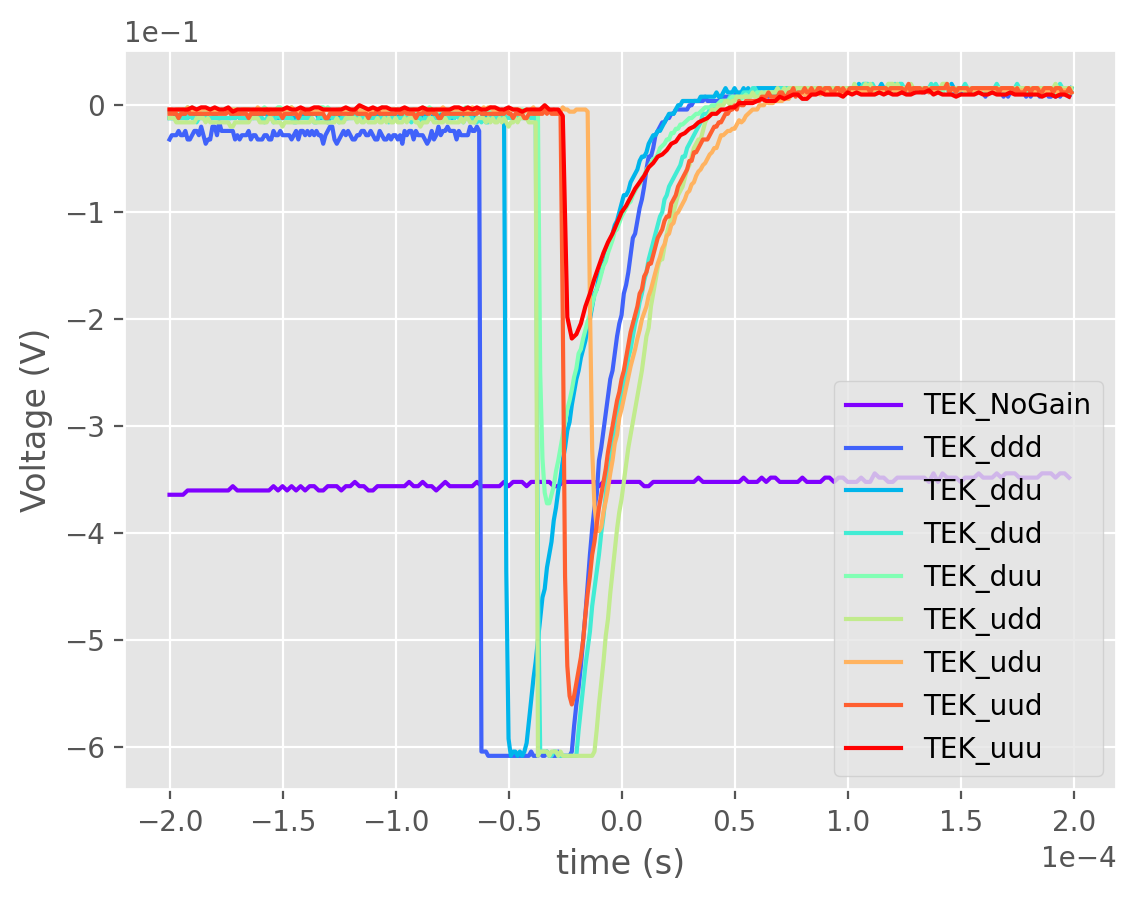

In [5]:
plot_data_tbs(output_dict, -0.0002, 0.0002, 'all')

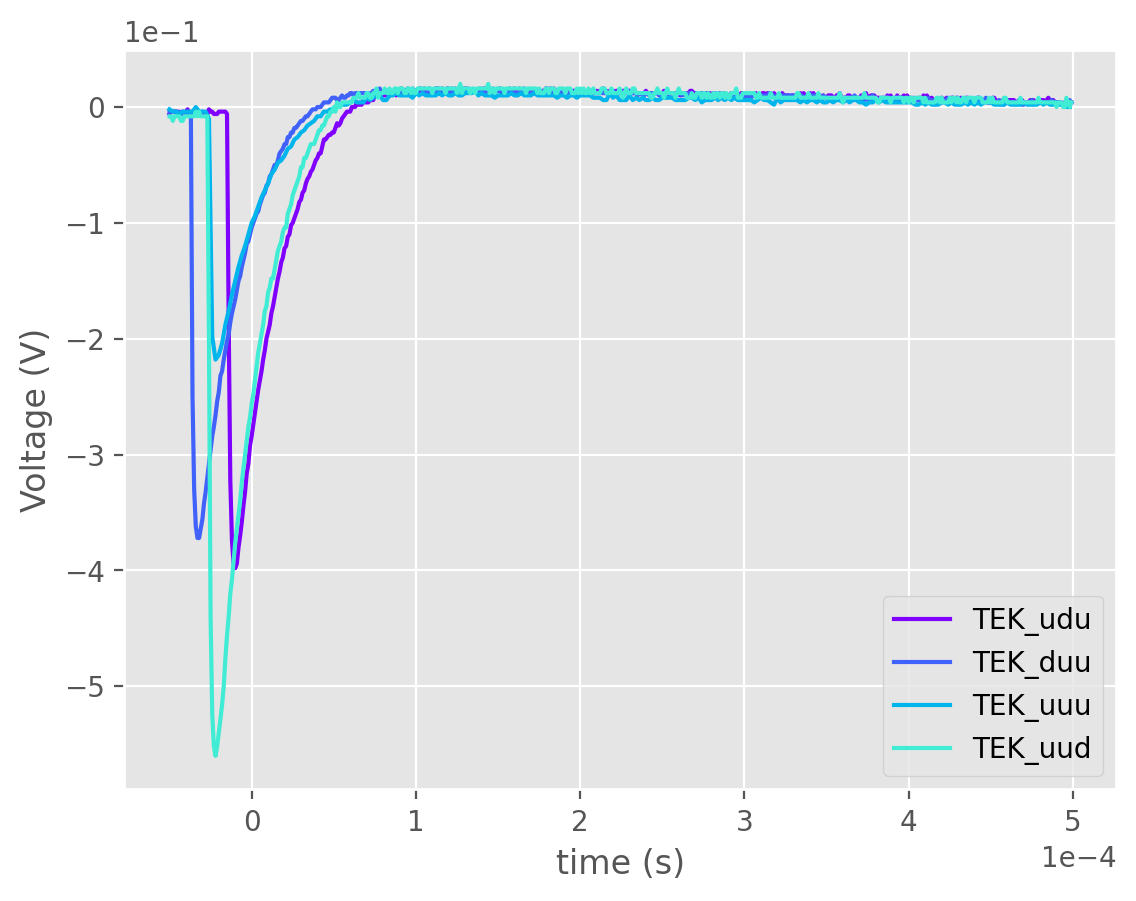

In [5]:
plot_data_tbs(output_dict, -0.5*10**-4, 5*10**-4, ['TEK_udu','TEK_duu', 'TEK_uuu', 'TEK_uud'])

In [6]:
tx = np.array(output_dict['TEK_udu']['horizontal'])
vy = np.array(output_dict['TEK_udu']['vertical']) 

peaks, peaks_dict = find_peaks(-vy, height=None, prominence=0.1, width=1, rel_height=0.5)

print(peaks_dict)

{'prominences': array([0.396]), 'left_bases': array([604]), 'right_bases': array([735]), 'widths': array([22.88405797]), 'width_heights': array([0.2]), 'left_ips': array([616.11594203]), 'right_ips': array([639.])}


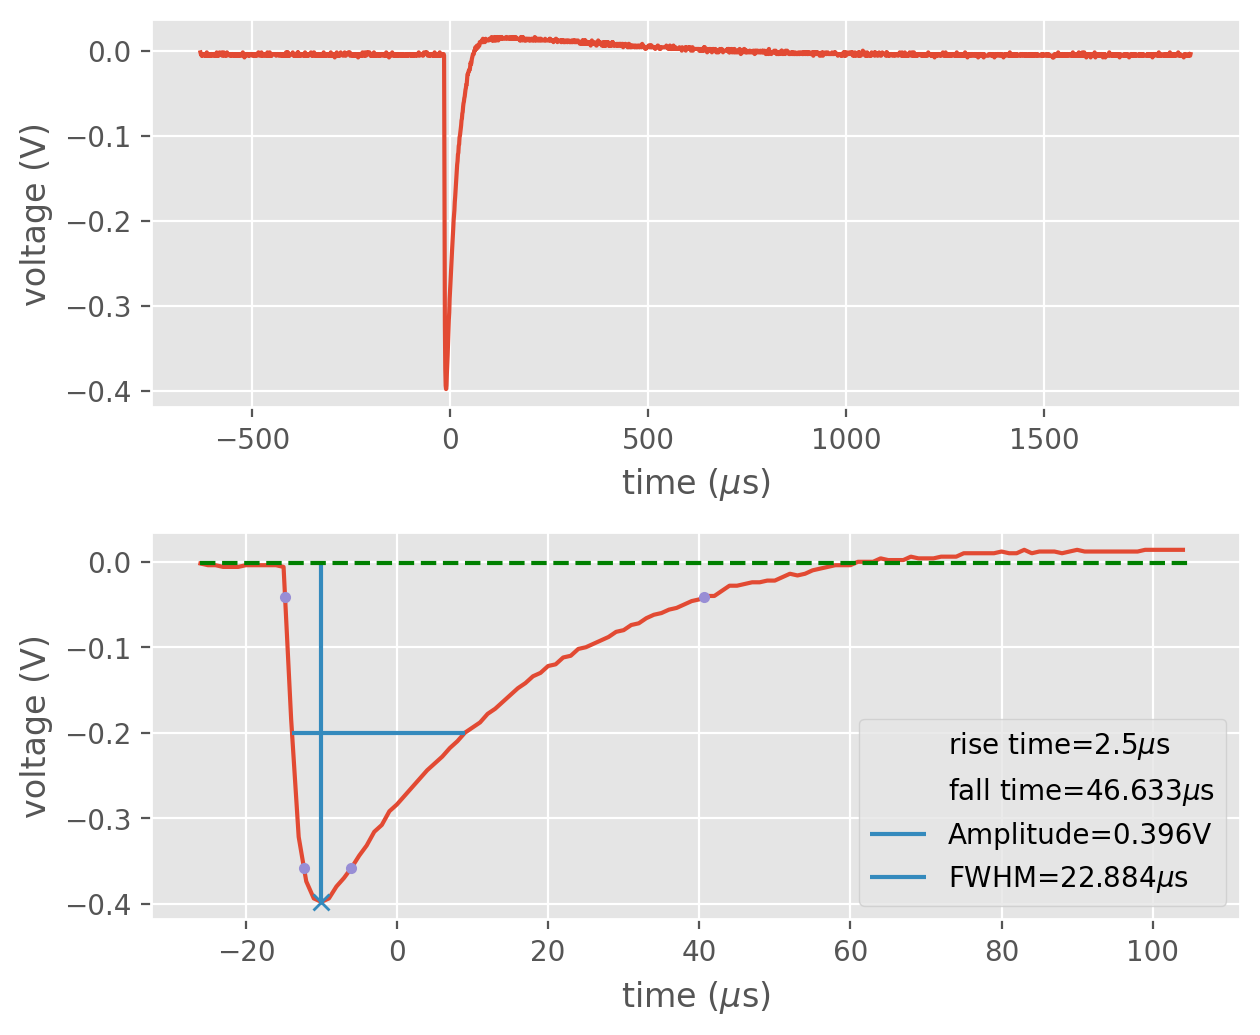

In [14]:
analyze_peaks(tx, vy, peaks, peaks_dict)

(-20.0, 20.0)

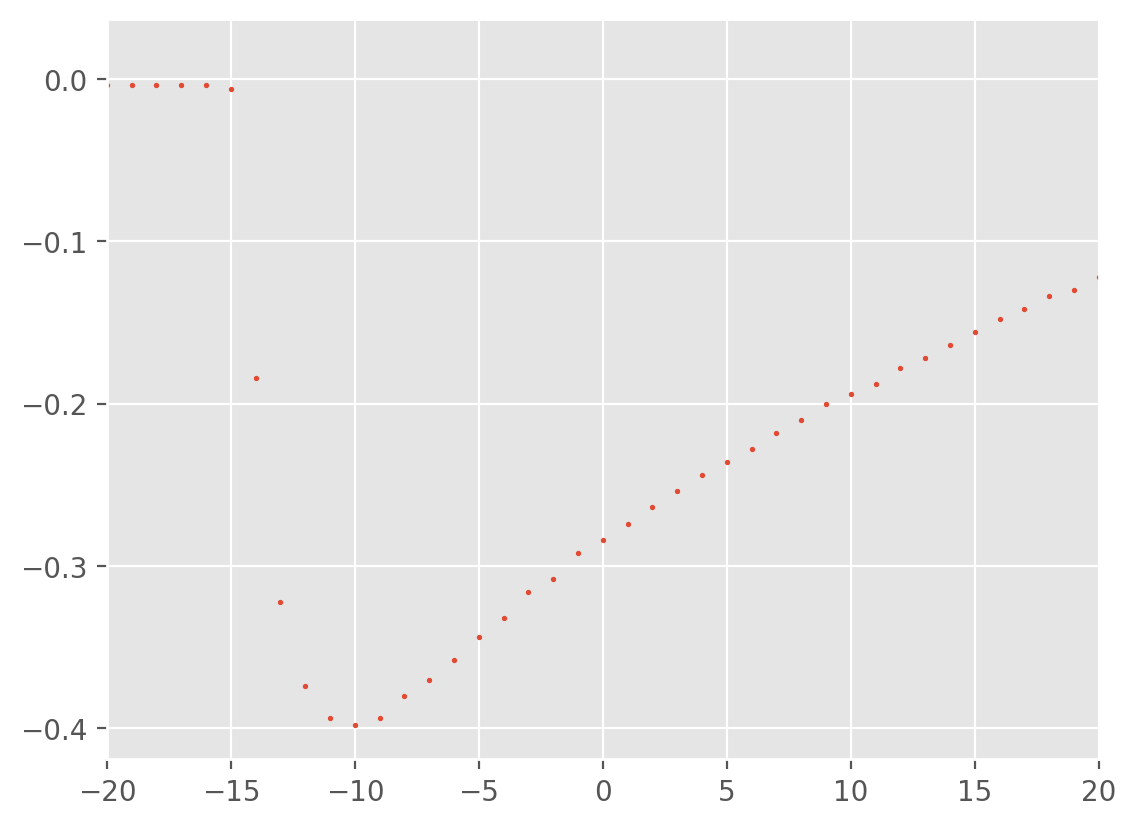

In [21]:
#fig = plt.figure()

plt.scatter(tx*10**6,vy, s=2)
plt.xlim([-20,20])
#plt.xlim([-0.00002,0.00005])

In [22]:
(tx[1] - tx[0])*10**6

1.0000000000000242

In [16]:
tx = np.array(output_dict['TEK_duu']['horizontal'])
vy = np.array(output_dict['TEK_duu']['vertical']) 

peaks, peaks_dict = find_peaks(-vy, height=None, prominence=0.1, width=1, rel_height=0.5)

print(peaks_dict)

{'prominences': array([0.37]), 'left_bases': array([501]), 'right_bases': array([648]), 'widths': array([23.15819672]), 'width_heights': array([0.187]), 'left_ips': array([533.74180328]), 'right_ips': array([556.9])}


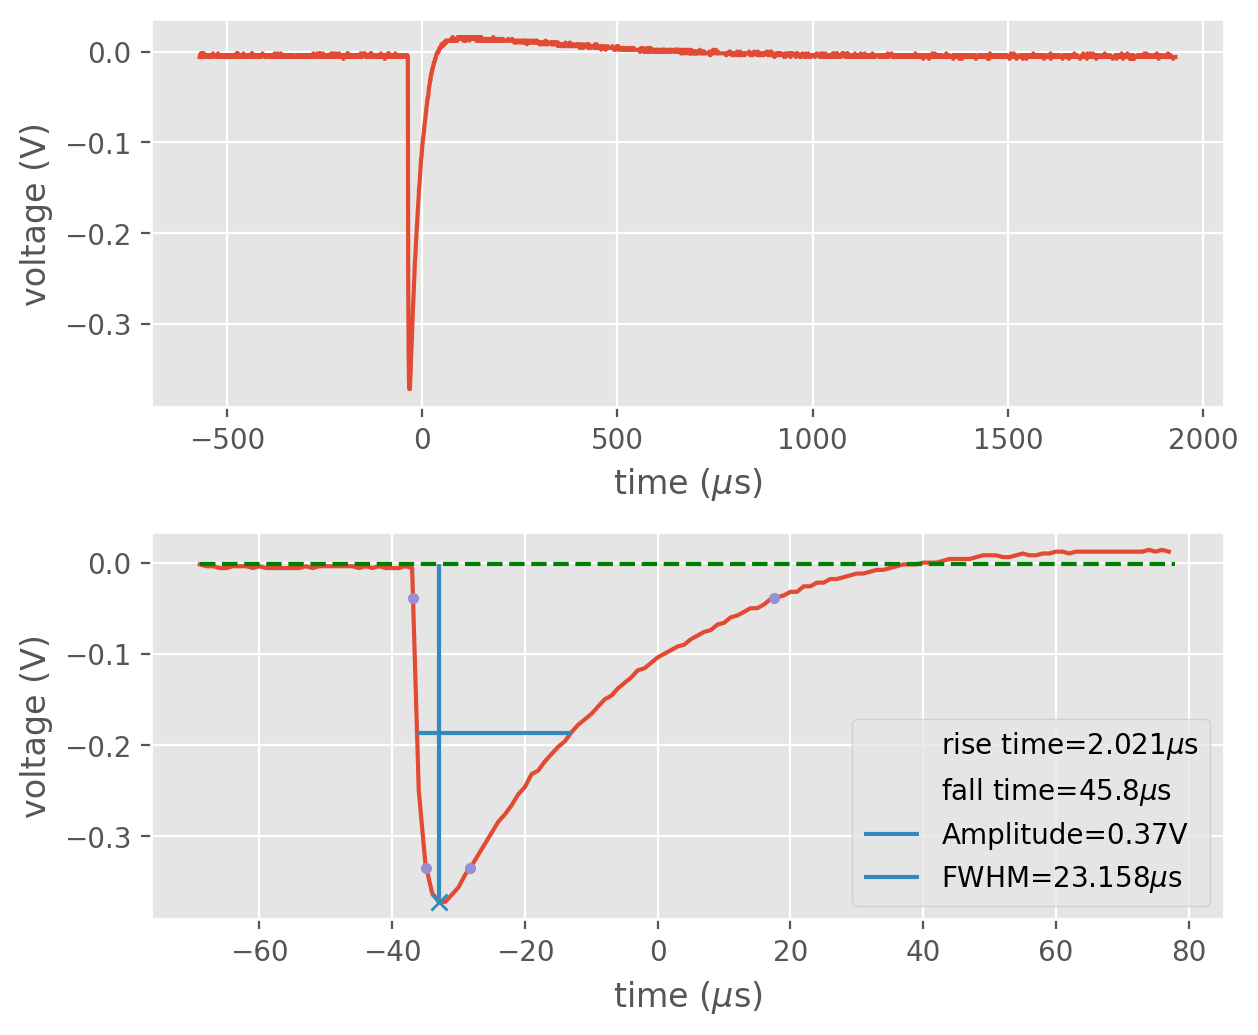

In [17]:
analyze_peaks(tx, vy, peaks, peaks_dict)

In [18]:
tx = np.array(output_dict['TEK_uuu']['horizontal'])
vy = np.array(output_dict['TEK_uuu']['vertical']) 

peaks, peaks_dict = find_peaks(-vy, height=None, prominence=0.1, width=1, rel_height=0.5)

print(peaks_dict)

{'prominences': array([0.218]), 'left_bases': array([893]), 'right_bases': array([978]), 'widths': array([11.57340426]), 'width_heights': array([0.109]), 'left_ips': array([897.52659574]), 'right_ips': array([909.1])}


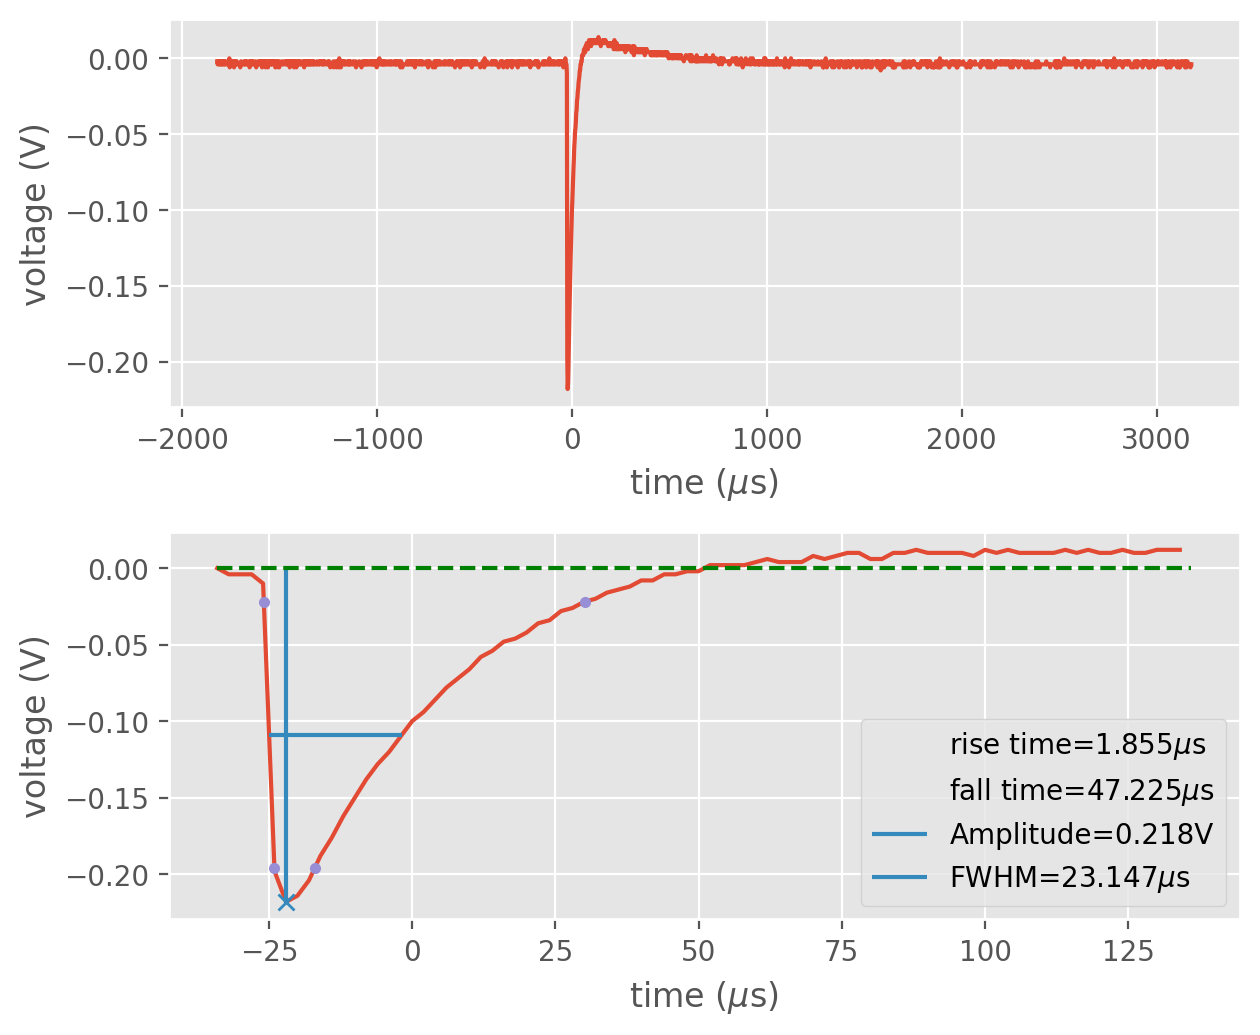

In [19]:
analyze_peaks(tx, vy, peaks, peaks_dict)

In [20]:
tx = np.array(output_dict['TEK_uud']['horizontal'])
vy = np.array(output_dict['TEK_uud']['vertical']) 

peaks, peaks_dict = find_peaks(-vy, height=None, prominence=0.1, width=1, rel_height=0.5)

print(peaks_dict)

{'prominences': array([0.556]), 'left_bases': array([538]), 'right_bases': array([697]), 'widths': array([23.15833333]), 'width_heights': array([0.282]), 'left_ips': array([544.34166667]), 'right_ips': array([567.5])}


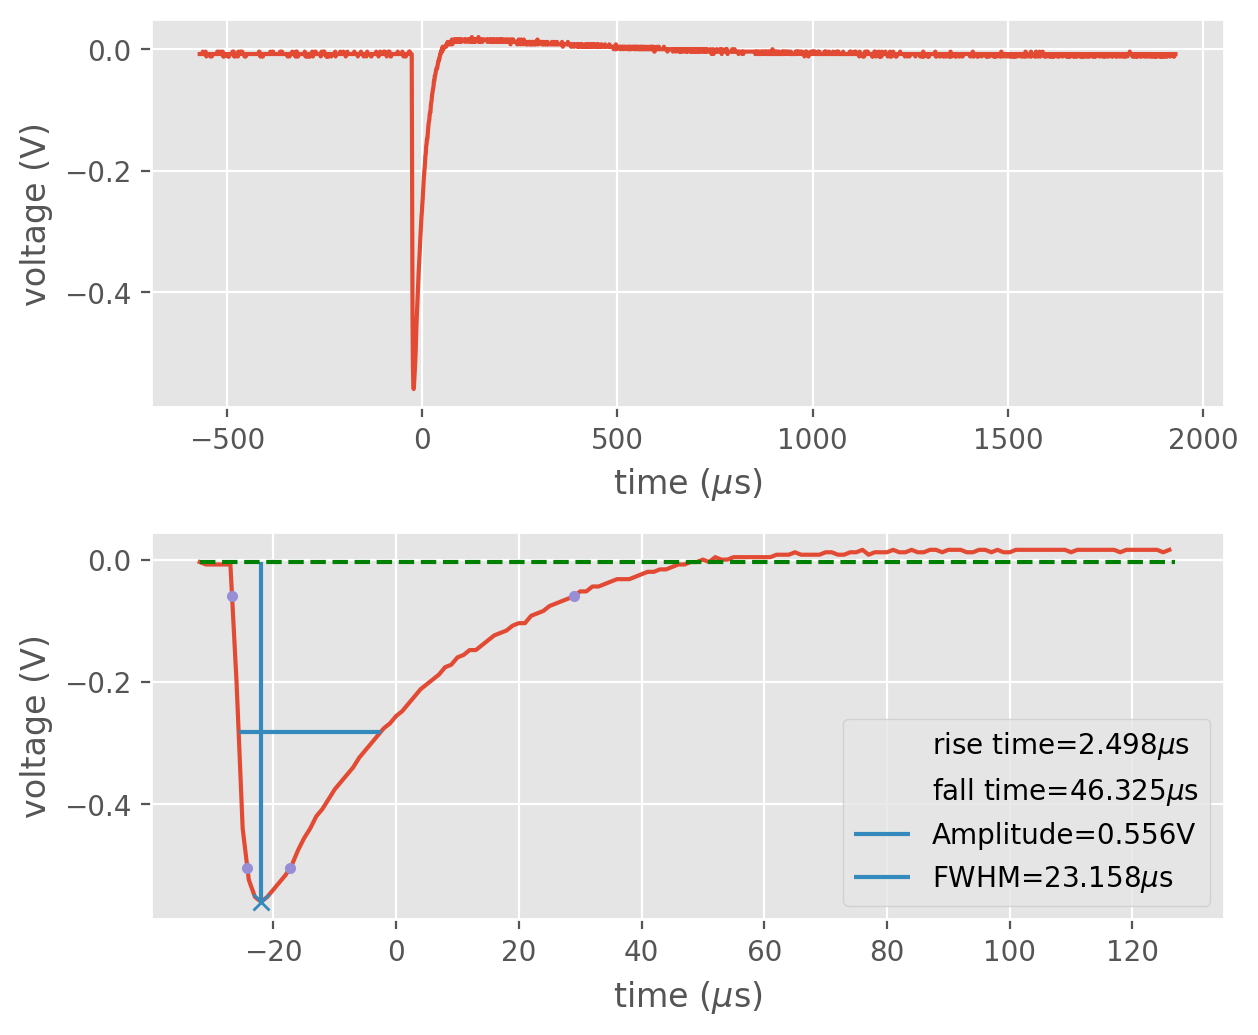

In [21]:
analyze_peaks(tx, vy, peaks, peaks_dict)

In [27]:
tx = np.array(output_dict['TEK_NoGain']['horizontal'])
vy = np.array(output_dict['TEK_NoGain']['vertical']) 

peaks, peaks_dict = find_peaks(-vy, height=None, prominence=0.1, width=1, rel_height=0.5)

print(peaks_dict)

{'prominences': array([0.176, 0.176]), 'left_bases': array([761, 761]), 'right_bases': array([2084, 2084]), 'widths': array([140.13043478, 140.13043478]), 'width_heights': array([0.42, 0.42]), 'left_ips': array([765.86956522, 765.86956522]), 'right_ips': array([906., 906.])}


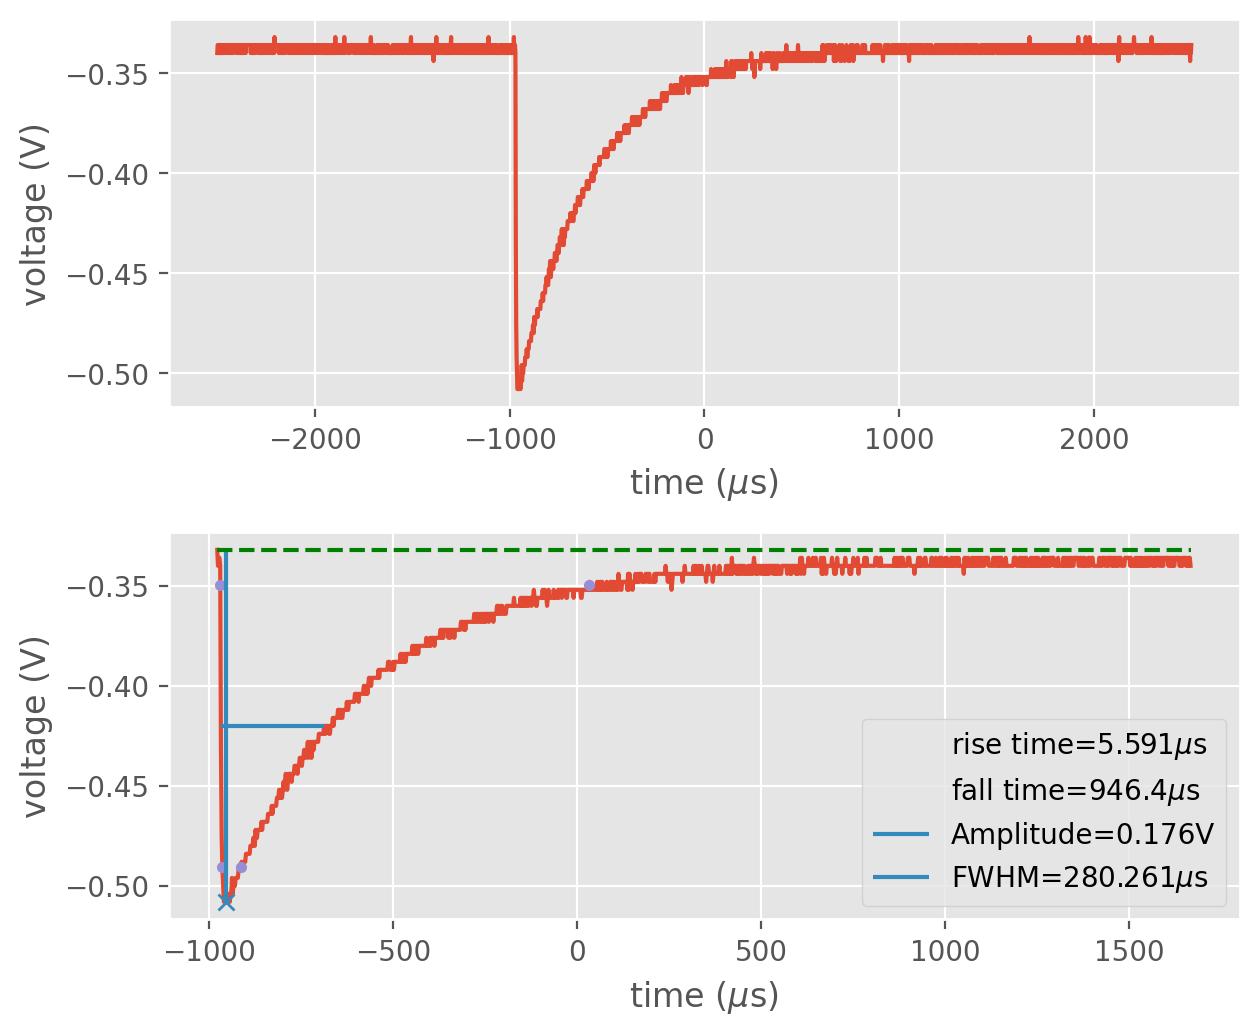

In [28]:
analyze_peaks(tx, vy, peaks, peaks_dict)